In [1]:
import sys  
sys.path.insert(0, './codes')
from numpy import (pi,e,cos,sin,tan,linspace,arange,sqrt,array,shape,reshape,zeros,ones,)
from tqdm.notebook import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
import itertools
from math import *
from timeit import default_timer as timer
from pade_func import pade_analytic_continuation
from scipy.optimize import fsolve
#### NOTE: hbar and k_B are equal to 1

class Hubbard:
    """Hubbard model"""
    from pade_func import pade_analytic_continuation
    def __init__(self, U, T, params):
        self.U = U
        self.T = T
        self.beta = 1./T
        self.N_iomega=params[0]
        self.omega_n=pi/self.beta*( 2 * array(range(-N_iomega//2,N_iomega//2)) + 1 )
        #self.omega_n=pi/self.beta*( 2 * array(range(0,N_iomega)) + 1 )
        
        self.mu=self.U/2*0
        self.cond=params[2]
        self.dtau=params[1]
        self.sigma_loc=self._get_self_energy()
        
        self.Gloc=get_Gloc(self.omega_n,self.sigma_loc,self.mu)
        self.emin=-10;self.emax=10;self.energy=linspace(self.emin,self.emax,1000)
            
    def _get_self_energy(self):
        """Returns initial condition (metallic or insulator)"""
        if self.cond=='I':
            self.sigma_loc = -1/(1j*self.omega_n)
        if self.cond=='M':
            self.sigma_loc = zeros(len(self.omega_n))
        return self.sigma_loc
    
    
    def plot_spectrum(self):
        A=self.get_spectrum()
        fig, ax = plt.subplots(figsize=(12,6), nrows=1, ncols=1)
        plt.rcParams['font.size'] = 20
        plt.rcParams['font.family'] = 'Helvetica' #TODO: change to Helvetica?
        plt.rcParams['font.style'] = 'normal'
        plt.rcParams['xtick.labelsize']=15
        plt.rcParams['ytick.labelsize']=15
        plt.plot(self.energy, A,'k')
        #plt.plot(self.energy[energy>0], A[self.energy<0][::-1],'r')
        plt.ylim(0,0.5)
        plt.xlabel(r'$\omega$')
        plt.ylabel(r'$A(\omega)$')
        plt.title(f'Spectrum for U={self.U:.2f}, T={self.T:.3f}')
        plt.plot()
        
    def get_spectrum(self):
        GF = pade_analytic_continuation(wnn=self.omega_n,nw_out=len(self.energy), emin=self.emin, emax=self.emax, gff=self.Gloc)[0]
        A=-GF.imag/pi
        return A
    
    def update(self,new_sigma):
        """after IPT, update the configuration with new Σimp. This changes the Σloc, Gloc and 
        the chemical potential which ensures µ-Re(Σloc)=0 which means we are at half filling
        (Re(Σloc) is constant).
        """

        self.sigma_loc=1j*new_sigma.imag + self.U/2 #Re(Σloc)=U/2
        self.mu=(self.sigma_loc[-1]).real # µ-Re(Σloc)=0
        self.Gloc=get_Gloc(self.omega_n,self.sigma_loc,self.mu)
        self.Gloc = 1j*(self.Gloc).imag + 0*1e-12

def dos_bethe (omega, D):
    '''
    density of states of a Bethe lattice with infinite connectivity 
    (from the analytical expression of the non interacting GF)

    input:      omega       real frequency/energy 
                D           bandwidth, the density of states is non zero for |omega|<D

    output:     rho(omega)  densiy of states, rho(w)=2*sqrt(D^2-w^2)/pi*D^2
    '''

    return np.sqrt(4*D**2-omega**2)/(2*np.pi*D**2)

def my_fft(G_iw, tau, omega_n): # freq to imag. time
    '''
    Fourier transform of a function G(i*omega_n) where i*omega_n are Matzubara frequencies
    (needed to perform the Iterative Perturbation Theory Step)
    
    input:      func        G(i*omega_n): function of i*omega (Matzubara frequencies)
                beta        inverse temperature
                tau         imaginary time        

    output:     G(tau)      function of the imaginary time (tau), G(tau)=(1/beta)* sum_(w_n)  (e^i*w_n*tau)*G(i*omega_n)
    '''
    
    #nn = np.linspace(start=0, stop=N_iomega, num=N_iomega, dtype=int)
    #matz_frequencies = np.pi*(1/beta) * (2*nn + 1)
    #domega=(matz_frequencies[-1]-matz_frequencies[0])/beta
    
    #G_iw=G_iw[omega_n > 0]
    #omega_n = omega_n[omega_n > 0]
    
    G_iw_prime = G_iw - 1/(1j*omega_n)
    
    
    exponential_iw = np.exp(np.inner(-1j*omega_n[:,np.newaxis],tau[:,np.newaxis]))
    
    G_iw_prime=G_iw_prime[omega_n > 0]
    exponential_iw = exponential_iw[omega_n > 0]
    intg1=np.real(exponential_iw*G_iw_prime[:,np.newaxis]) 
    
    #intg2=
    beta=tau[-1]
    ans1=np.sum(intg1,axis=0)*2/beta

    return  ans1 - np.sign(tau)/2 

def my_ifft(G_tau, tau, omega_n): # imag. time to freq
    '''
    Inverse Furier transform of a function G(tau) to G(iwn) where iwn are Matzubara frequencies
    (needed to perform the Iterative Perturbation Theory Step)
    
    input:      func        G(i*omega_n): function of i*omega (Matzubara frequencies)
                beta        inverse temperature
                tau         imaginary time        

    output:     G(iwn)      function of the matsubara frequencies
    '''
    exponential_tau = np.exp(np.inner(tau[:,np.newaxis],1j*omega_n[:,np.newaxis]))

    return  np.sum(exponential_tau * G_tau[:,np.newaxis],axis=0) * (tau[-1]-tau[0])/len(tau)

def IPT_solver(G0,config,dt=1e-3):
    '''
    finds the self energy of the auxiliary Anderson impurtity model Sigma_imp
    from this it evaluates also the interacting Green's function of the auxiliary system (G coursive)

    input:      impurity_non_int_greens_func        G_0 (iomega) coursive: non interacting Green's function of the auxiliary system
                                                                           encoded in step (3) and evaluated on Matzubara frequency
                iomega                              Matzubara frequency i*omega_n
                U                                   impurity interaction
                beta                                inverse temperature  

    output:     impurity_self_energy(iomega)        self energy of the auxiliary system    Sigma_imp(iw)=U/2 + U^2 * int_0^beta d(tau) (e^i*w_n*tau) * G_0^shifted(tau)^3
                                                                                           knowing G_0^shifted(iw)= (G_0(iw)^-1  - U/2)^-1     where all the G are coursive
                impurity_int_greens_func(iomega)    interacting GF of the auxiliary system   G(iw) = (  G_0(iw)^-1 - Sigma_imp(iw)  )^-1          where all the G are coursive

    note: this fucntion uses the function fourier_trans_to_imag_time() to convert G_0^shifted(iw) coursive in imaginary time
    '''
    omega_n=config.omega_n; beta=config.beta; U=config.U;
    # I calculate G_0_shifted(iw) as a function of iomega
    G0_shifted = 1 / ( (1/G0) - U/2 )

    # I calculate the fourier transform G_0_shifted(tau)
    tau=np.arange(0*config.dtau,beta,config.dtau)
    G0_tau_shifted_ = my_fft(G0_shifted, tau, omega_n)
    # I calculate the integral
    G0_tau_cube=G0_tau_shifted_**3
    integral = my_ifft(G0_tau_cube, tau, omega_n)  

    # I get Sigma_imp and the interacting GF of the impurity
    Sigma_imp = U/2 + U**2  * integral

    #G_0_iw = impurity_non_int_greens_func
    G_imp = 1 / ( 1/G0 - Sigma_imp )
    return Sigma_imp

def get_Gloc(omega_n,sigma_loc,mu):
    '''
    get local interacting green's function
    input:    rho           vector with density of states evaluated at all the energy steps of the integral
              omega_n       vector with matzubara frequencies form O to N_matz_freq
              eps           values of energies of the integration = eps=np.linspace(-D,D,len(omega_n))
    '''
    D=1;
    eps=np.linspace(-2*D,2*D,1000)
    rho=dos_bethe(eps,D)
    Gloc=zeros(len(omega_n))+0*1j
    d_eps=(eps[-1]-eps[0])/len(eps)
    for i in range(len(eps)):
        Gloc += rho[i]/(1j*omega_n+mu-eps[i]-sigma_loc)*d_eps
    return Gloc

def do_DMFT_loop(config,Gtol=1e-5,show_info=False,maxiter=1000):
    #pbar = tqdm_notebook(total=100)
    c=0
    dist=0.1
    start = timer()
    while dist>Gtol:
        """dt and N_iomega must be adjusted adaptively"""
        # step 2: get local GF (already initialized by Hubbard class)
        # step 3: obtain the impurity GF
        G0= 1/( (1/config.Gloc) + config.sigma_loc)
        # step 4: solve impurity model
        Sigma_imp= IPT_solver(G0,config,dt=config.dtau)
        G_loc_new=get_Gloc(config.omega_n,Sigma_imp,(Sigma_imp[-1]).real)
        """
        fig, ax = plt.subplots(figsize=(12,8), nrows=1, ncols=1)
        tau=np.arange(config.dtau,config.beta,config.dtau)
        Gtau=my_fft(G_loc_new, tau, config.omega_n)
        plt.plot(tau,Gtau,'.')
        plt.show()
        """
        # step 5:
        if show_info:
            if np.mod(c,5)==0:
                sys.stdout.flush()
                sys.stdout.write(f'converging (U,T)=({round(config.U,2)}, {round(config.T,3)}). iteration {c}: distance = {dist:.2e}\r')
                #pbar.set_description(f"iteration = {c:d}, with dist. {dist:.2e}")
        #dist=np.abs(np.sum(config.Gloc - G_loc_new))
        dist=np.sum(np.abs(config.Gloc.imag - G_loc_new.imag))      
        alpha=.6
        
        #updating the configuration
        config.update(alpha*Sigma_imp+(1-alpha)*config.sigma_loc)
        c += 1
        if c>maxiter: print(f'Reached maximum iteration number: {max_iter}');break
    #-------------------- end of the loop --------------------#
    end = timer()
    elapsed=end - start
    if elapsed<60:print(f'Converged (U,T)=({round(config.U,2)}, {round(config.T,3)}). Elapsed time: {round(elapsed,2)} seconds.' )
    else:print(f'Converged (U,T)=({round(config.U,2)}, {round(config.T,3)}). Elapsed time: {round(elapsed/60,2)} minutes.' )
        
def do_phase_diagram(params,Ulist,Tlist):
    for T in Tlist:
        #we start from an initial condition for U here
        config=Hubbard(Ulist[0],T,params)
        for U in Ulist:
            config.U = U
            strU=str(round(U,2));strT=str(round(T,3))
            
            if U==Ulist[0]:#load the latest initial condition
                try:
                    sigma_load=np.genfromtxt(f'sigma_files/sigma_M_U{strU[0]}p{strU[2:]}_T{strT[0]}p{strT[2:]}.dat',dtype=np.complex128)
                    config.update(sigma_load)
                    print('Starting from pre-existing converged result.')
                    continue
                except:
                    print('No previous converged result found!')
                    pass
            do_DMFT_loop(config,show_info=True)
            config.Gloc = 1j*(config.Gloc).imag + 0*1e-10
            plt.clf()
            config.plot_spectrum()
            plt.show()
            #write the converged sigma which is going to be the initial condition for the next U.
            #important remark is to know from which initial condition we have started: metallic (M) or insulating (I)
#            np.savetxt(f'sigma_files/sigma_{config.cond}_U{strU[0]}p{strU[2:]}_T{strT[0]}p{strT[2:]}.dat',config.sigma_loc)
            

Text(0.5, 1.0, 'Imag. Part of Self-Energy')

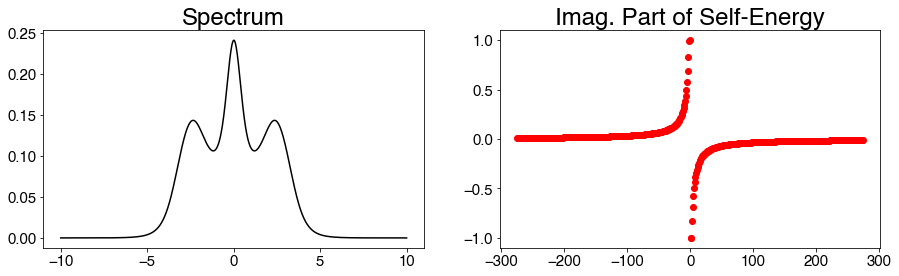

In [49]:
plt.rcParams['font.size'] = 20
plt.rcParams['font.family'] = 'Helvetica' #TODO: change to Helvetica?
plt.rcParams['font.style'] = 'normal'
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15


U=3.7;T=0.175; beta=1/T;


N_iomega=500; dtau=5e-3; 
params=[N_iomega,dtau,'M']
hub=Hubbard(U,T,params)
energy=linspace(-10,10,1000)


strU=str(round(U,2));strT=str(round(T,3))
sigma_load=np.genfromtxt(f'sigma_files_I/sigma_I_U{strU[0]}p{strU[2:]}_T{strT[0]}p{strT[2:]}.dat',dtype=np.complex128)
hub.update(sigma_load)
fig, ax = plt.subplots(figsize=(15,4), nrows=1, ncols=2)



A=hub.get_spectrum()
self_energy=hub.sigma_loc

ax[0].plot(hub.energy,A,'k')
ax[0].set_title('Spectrum')
ax[1].plot(hub.omega_n,self_energy.imag,'ro')
ax[1].set_title('Imag. Part of Self-Energy')

Filling Factor = 0.50


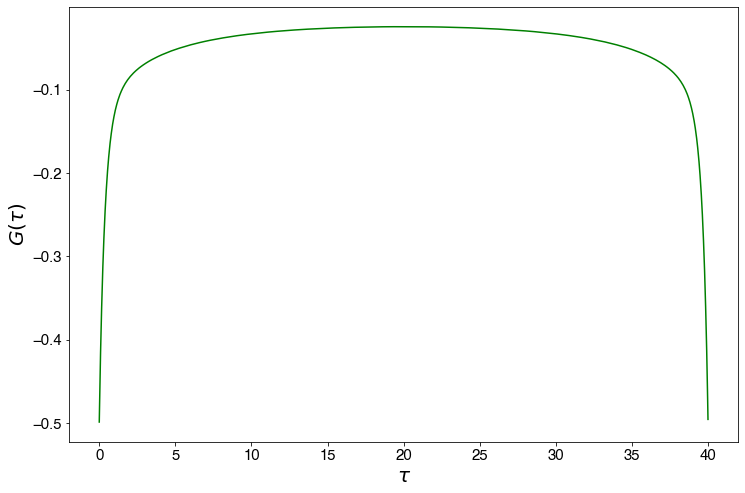

In [46]:
plt.rcParams['font.size'] = 20
plt.rcParams['font.family'] = 'Helvetica' #TODO: change to Helvetica?
plt.rcParams['font.style'] = 'normal'
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15

fig, ax = plt.subplots(figsize=(12,8), nrows=1, ncols=1)
tau=np.arange(0.001,beta,dtau)
G0= 1/( (1/hub.Gloc) + hub.sigma_loc)
Gtau=my_fft(hub.Gloc, tau, hub.omega_n)
plt.plot(tau,Gtau,'g-')
ax.set_ylabel(r'$G(\tau)$')
ax.set_xlabel(r'$\tau$')
#plt.xlim(-1.1,42)
print(f'Filling Factor = {-Gtau[-1]:.2f}')